In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings("ignore")

In [3]:
# configurations affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
# chargement des données
events = pd.read_csv('../data/raw/events.csv', sep=',')
category_tree = pd.read_csv('../data/raw/category_tree.csv', sep=',')
item_properties_part1 = pd.read_csv('../data/raw/item_properties_part1.csv', sep=',')
item_properties_part2 = pd.read_csv('../data/raw/item_properties_part2.csv', sep=',')



In [7]:
# inspection detaillé evevnts.csv
print("\nINSPECTION DETAILLEE - EVENTS.CSV")
print("=" * 60)

print("STRUCTURE:")
print(f"Dimensions: {events.shape[0]:,} lignes x {events.shape[1]} colonnes")
print(f"Memoire: {events.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nCOLONNES ET TYPES:")
print(events.dtypes)

print("\nVALEURS MANQUANTES:")
for col in events.columns:
    na_count = events[col].isnull().sum()
    if na_count > 0:
        print(f"  {col}: {na_count:,} ({na_count/len(events)*100:.2f}%)")

print("\nAPERÇU DES DONNEES:")
print(events.head(3))



INSPECTION DETAILLEE - EVENTS.CSV
STRUCTURE:
Dimensions: 2,756,101 lignes x 5 colonnes
Memoire: 244.9 MB

COLONNES ET TYPES:
timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

VALEURS MANQUANTES:
  transactionid: 2,733,644 (99.19%)

APERÇU DES DONNEES:
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN


In [8]:
#inspection category_tree.csv
print("\nINSPECTION - CATEGORY_TREE.CSV")
print("=" * 60)

print(f"Dimensions: {category_tree.shape[0]:,} lignes x {category_tree.shape[1]} colonnes")
print(f"Colonnes: {list(category_tree.columns)}")

print("\nVALEURS MANQUANTES:")
for col in category_tree.columns:
    na_count = category_tree[col].isnull().sum()
    if na_count > 0:
        print(f"  {col}: {na_count:,} ({na_count/len(category_tree)*100:.2f}%)")

print("\nAPERÇU:")
print(category_tree.head(5))

# analyse hierarchie categories
if 'categoryid' in category_tree.columns and 'parentid' in category_tree.columns:
    categories_sans_parent = category_tree[category_tree['parentid'].isna()].shape[0]
    print(f"\nCategories racines (sans parent): {categories_sans_parent}")




INSPECTION - CATEGORY_TREE.CSV
Dimensions: 1,669 lignes x 2 colonnes
Colonnes: ['categoryid', 'parentid']

VALEURS MANQUANTES:
  parentid: 25 (1.50%)

APERÇU:
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0

Categories racines (sans parent): 25


In [9]:
# inspection item_properties
print("\nINSPECTION - ITEM_PROPERTIES")
print("=" * 60)

# Combiner les deux parties
item_properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)
print(f"Proprietes combinees: {item_properties.shape[0]:,} lignes")

print(f"Colonnes: {list(item_properties.columns)}")

print("\nVALEURS MANQUANTES:")
for col in item_properties.columns:
    na_count = item_properties[col].isnull().sum()
    if na_count > 0:
        print(f"  {col}: {na_count:,} ({na_count/len(item_properties)*100:.2f}%)")

print("\nAPERÇU:")
print(item_properties.head(5))

# types de proprietes
if 'property' in item_properties.columns:
    print(f"\nTYPES DE PROPRIETES UNIQUES:")
    properties_count = item_properties['property'].value_counts().head(10)
    for prop, count in properties_count.items():
        print(f"  {prop}: {count:,}")



INSPECTION - ITEM_PROPERTIES
Proprietes combinees: 20,275,902 lignes
Colonnes: ['timestamp', 'itemid', 'property', 'value']

VALEURS MANQUANTES:

APERÇU:
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513

TYPES DE PROPRIETES UNIQUES:
  888: 3,000,398
  790: 1,790,516
  available: 1,503,639
  categoryid: 788,214
  6: 631,471
  283: 597,419
  776: 574,220
  678: 481,966
  364: 476,486
  202: 448,938


In [10]:
# combien itemproperties
print(f"events.csv : {events.shape[0]:,} lignes x {events.shape[1]} colonnes")
print(f"category_tree.csv : {category_tree.shape[0]:,} lignes x {category_tree.shape[1]} colonnes")
print(f"item_properties : {item_properties.shape[0]:,} lignes x {item_properties.shape[1]} colonnes")

events.csv : 2,756,101 lignes x 5 colonnes
category_tree.csv : 1,669 lignes x 2 colonnes
item_properties : 20,275,902 lignes x 4 colonnes


In [11]:
# netoyage et preparation
print("\n2. NETTOYAGE ET PREPARATION")
print("-" * 40)

# CRÉER LE DOSSIER AVANT TOUTE CHOSE
os.makedirs('../data/clean', exist_ok=True) 

# nettoyage events
events_clean = events.copy()
events_clean['datetime'] = pd.to_datetime(events_clean['timestamp'], unit='ms')
events_clean['transactionid'] = events_clean['transactionid'].fillna(0).astype(int)
events_clean['is_purchase'] = (events_clean['event'] == 'transaction').astype(int)
events_clean['is_addtocart'] = (events_clean['event'] == 'addtocart').astype(int)
events_clean['is_view'] = (events_clean['event'] == 'view').astype(int)
events_clean['date'] = events_clean['datetime'].dt.date
events_clean['hour'] = events_clean['datetime'].dt.hour
events_clean['day_of_week'] = events_clean['datetime'].dt.day_name()
print("Events nettoye et enrichi")

#Nettoyage category_tree
category_tree_clean = category_tree.copy()
category_tree_clean['parentid'] = category_tree_clean['parentid'].fillna(0).astype(int)
print("Category_tree nettoye")

# C. Nettoyage item_properties
item_properties_clean = item_properties.copy()
item_properties_clean['datetime'] = pd.to_datetime(item_properties_clean['timestamp'], unit='ms')
item_properties_clean['date'] = item_properties_clean['datetime'].dt.date
print("Item_properties nettoye")


2. NETTOYAGE ET PREPARATION
----------------------------------------
Events nettoye et enrichi
Category_tree nettoye
Item_properties nettoye


In [12]:
# sauvegerde des data nettoyées
os.makedirs('../data/clean', exist_ok=True)

# Sauvegarde events_clean
events_clean.to_csv('../data/clean/events_clean.csv', index=False)
print("Events sauvegarde -> data/clean/events_clean.csv")

# Sauvegarde category_tree_clean
category_tree_clean.to_csv('../data/clean/category_tree_clean.csv', index=False)
print("Category_tree sauvegarde -> data/clean/category_tree_clean.csv")

# Sauvegarde item_properties_clean
item_properties_clean.to_csv('../data/clean/item_properties_clean.csv', index=False)
print("Item_properties sauvegarde -> data/clean/item_properties_clean.csv")



Events sauvegarde -> data/clean/events_clean.csv
Category_tree sauvegarde -> data/clean/category_tree_clean.csv
Item_properties sauvegarde -> data/clean/item_properties_clean.csv


In [13]:
# metriques globales ecommerce
print("\n3. METRIQUES GLOBALES E-COMMERCE")
print("-" * 40)

# metriques de base
total_events = len(events_clean)
total_visitors = events_clean['visitorid'].nunique()
total_products = events_clean['itemid'].nunique()
total_transactions = events_clean['is_purchase'].sum()
total_categories = len(category_tree_clean)
total_item_properties = len(item_properties_clean)

print(f"EVENEMENTS: {total_events:,}")
print(f"VISITEURS UNIQUES: {total_visitors:,}")
print(f"PRODUITS UNIQUES: {total_products:,}")
print(f"TRANSACTIONS: {total_transactions:,}")
print(f"CATEGORIES: {total_categories:,}")
print(f"PROPRIETES PRODUITS: {total_item_properties:,}")

# taux de conversion
taux_conversion = (total_transactions / total_events) * 100
print(f"TAUX CONVERSION GLOBAL: {taux_conversion:.4f}%")

# periode d'analyse
periode_debut = events_clean['datetime'].min()
periode_fin = events_clean['datetime'].max()
duree_jours = (periode_fin - periode_debut).days
print(f"PERIODE: {periode_debut.date()} a {periode_fin.date()} ({duree_jours} jours)")


3. METRIQUES GLOBALES E-COMMERCE
----------------------------------------
EVENEMENTS: 2,756,101
VISITEURS UNIQUES: 1,407,580
PRODUITS UNIQUES: 235,061
TRANSACTIONS: 22,457
CATEGORIES: 1,669
PROPRIETES PRODUITS: 20,275,902
TAUX CONVERSION GLOBAL: 0.8148%
PERIODE: 2015-05-03 a 2015-09-18 (137 jours)



FUNNEL DE CONVERSION:
----------------------------------------


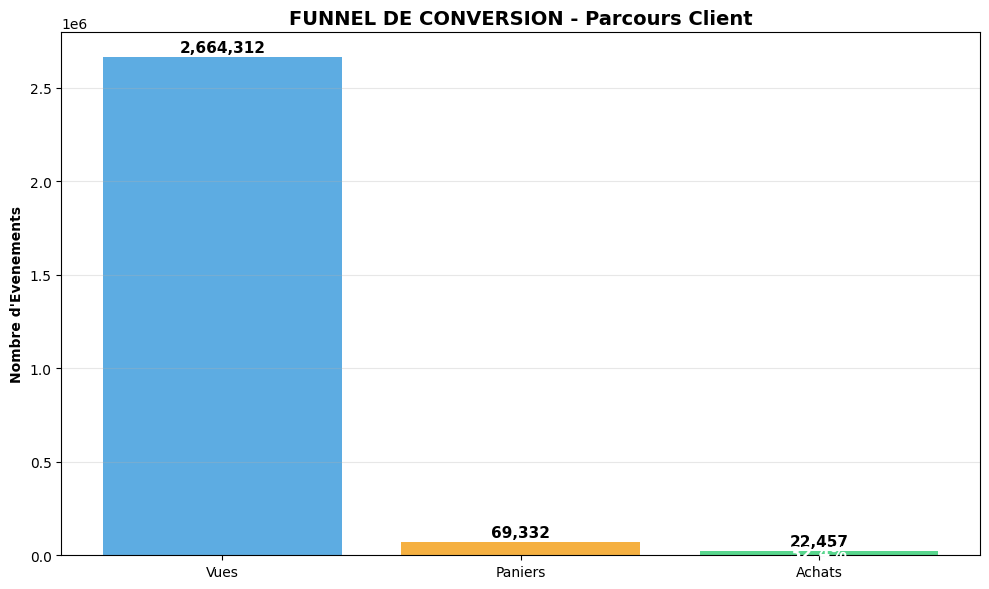

FUNNEL DE CONVERSION:
  Vues: 2,664,312
  Paniers: 69,332 (2.60% des vues)
  Achats: 22,457 (32.39% des paniers)


In [14]:
# visualisation funnel de conversion
print("\nFUNNEL DE CONVERSION:")
print("-" * 40)

# donnees du funnel
funnel_data = events_clean['event'].value_counts()
funnel_values = {
    'Vues': funnel_data.get('view', 0),
    'Paniers': funnel_data.get('addtocart', 0),
    'Achats': funnel_data.get('transaction', 0)
}

plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_values.keys(), funnel_values.values(), 
               color=['#3498db', '#f39c12', '#2ecc71'], alpha=0.8)

plt.title('FUNNEL DE CONVERSION - Parcours Client', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'Evenements', fontweight='bold')

# ajouter les valeurs et pourcentages
for i, (etape, valeur) in enumerate(funnel_values.items()):
    plt.text(i, valeur + 10000, f'{valeur:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Calcul pourcentages
    if i == 0:  # Vues = 100%
        pct = 100
    elif i == 1:  # Paniers vs Vues
        pct = (funnel_values['Paniers'] / funnel_values['Vues']) * 100
    else:  # Achats vs Paniers
        pct = (funnel_values['Achats'] / funnel_values['Paniers']) * 100 if funnel_values['Paniers'] > 0 else 0
        plt.text(i, valeur/2, f'{pct:.1f}%', ha='center', va='center', 
             fontsize=12, color='white', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# affichage console
print("FUNNEL DE CONVERSION:")
print(f"  Vues: {funnel_values['Vues']:,}")
print(f"  Paniers: {funnel_values['Paniers']:,} ({(funnel_values['Paniers']/funnel_values['Vues']*100):.2f}% des vues)")
print(f"  Achats: {funnel_values['Achats']:,} ({(funnel_values['Achats']/funnel_values['Paniers']*100):.2f}% des paniers)")


4. ANALYSE DETAILLEE ET VISUALISATIONS
----------------------------------------


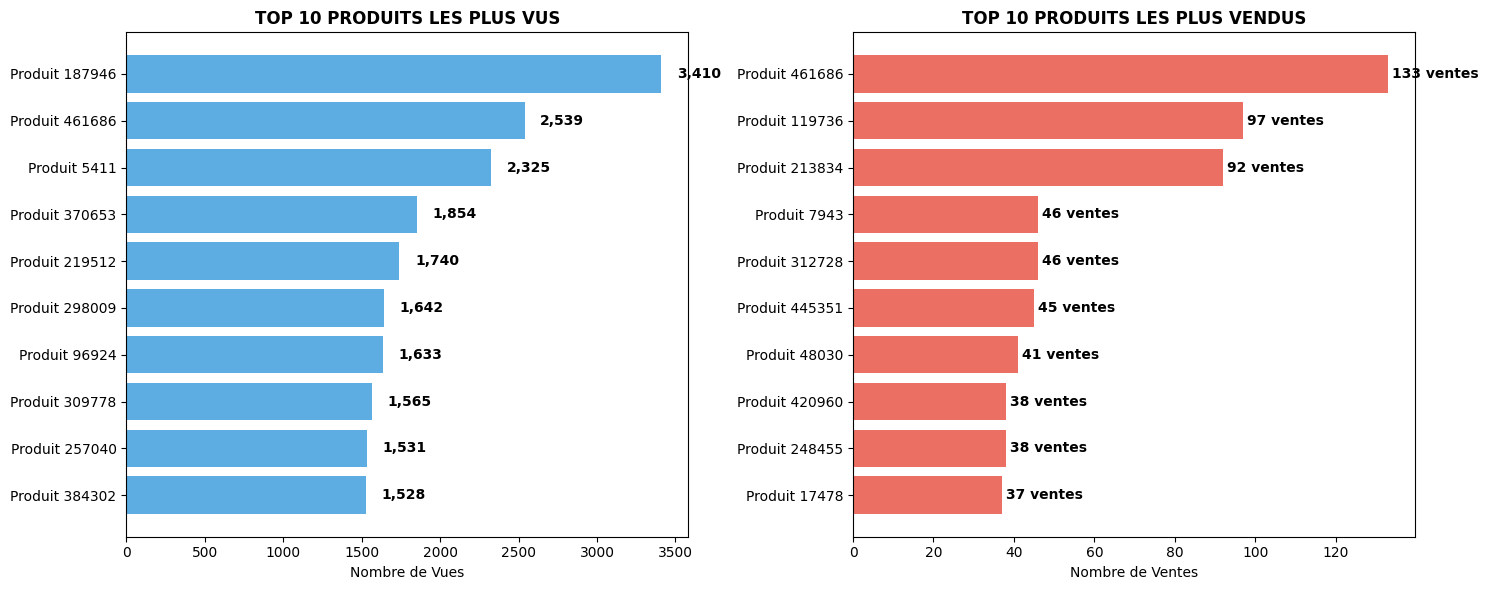

TOP 10 PRODUITS LES PLUS VUS:
   1. Produit 187946: 3,410 vues
   2. Produit 461686: 2,539 vues
   3. Produit 5411: 2,325 vues
   4. Produit 370653: 1,854 vues
   5. Produit 219512: 1,740 vues
   6. Produit 298009: 1,642 vues
   7. Produit 96924: 1,633 vues
   8. Produit 309778: 1,565 vues
   9. Produit 257040: 1,531 vues
  10. Produit 384302: 1,528 vues

TOP 10 PRODUITS LES PLUS VENDUS:
   1. Produit 461686: 133 achats
   2. Produit 119736: 97 achats
   3. Produit 213834: 92 achats
   4. Produit 7943: 46 achats
   5. Produit 312728: 46 achats
   6. Produit 445351: 45 achats
   7. Produit 48030: 41 achats
   8. Produit 420960: 38 achats
   9. Produit 248455: 38 achats
  10. Produit 17478: 37 achats


In [15]:
# visualisation top produits
print("\n4. ANALYSE DETAILLEE ET VISUALISATIONS")
print("-" * 40)

# top produits par type d'evenement
top_vues = events_clean[events_clean['event'] == 'view']['itemid'].value_counts().head(10)
top_transactions = events_clean[events_clean['event'] == 'transaction']['itemid'].value_counts().head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# graphique top vues
ax1.barh([f'Produit {pid}' for pid in top_vues.index], top_vues.values, color='#3498db', alpha=0.8)
ax1.set_title('TOP 10 PRODUITS LES PLUS VUS', fontweight='bold', fontsize=12)
ax1.set_xlabel('Nombre de Vues')
ax1.invert_yaxis()
for i, v in enumerate(top_vues.values):
    ax1.text(v + 100, i, f'{v:,}', va='center', fontweight='bold')
    
# Graphique top ventes
ax2.barh([f'Produit {pid}' for pid in top_transactions.index], top_transactions.values, color='#e74c3c', alpha=0.8)
ax2.set_title('TOP 10 PRODUITS LES PLUS VENDUS', fontweight='bold', fontsize=12)
ax2.set_xlabel('Nombre de Ventes')
ax2.invert_yaxis()
for i, v in enumerate(top_transactions.values):
    ax2.text(v + 1, i, f'{v} ventes', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# affichage console
print("TOP 10 PRODUITS LES PLUS VUS:")
for i, (produit_id, nb_vues) in enumerate(top_vues.items(), 1):
    print(f"  {i:2d}. Produit {produit_id}: {nb_vues:,} vues")

print("\nTOP 10 PRODUITS LES PLUS VENDUS:")
for i, (produit_id, nb_ventes) in enumerate(top_transactions.items(), 1):
    print(f"  {i:2d}. Produit {produit_id}: {nb_ventes:,} achats")


VISUALISATION TEMPORELLE DE L'ACTIVITE
----------------------------------------


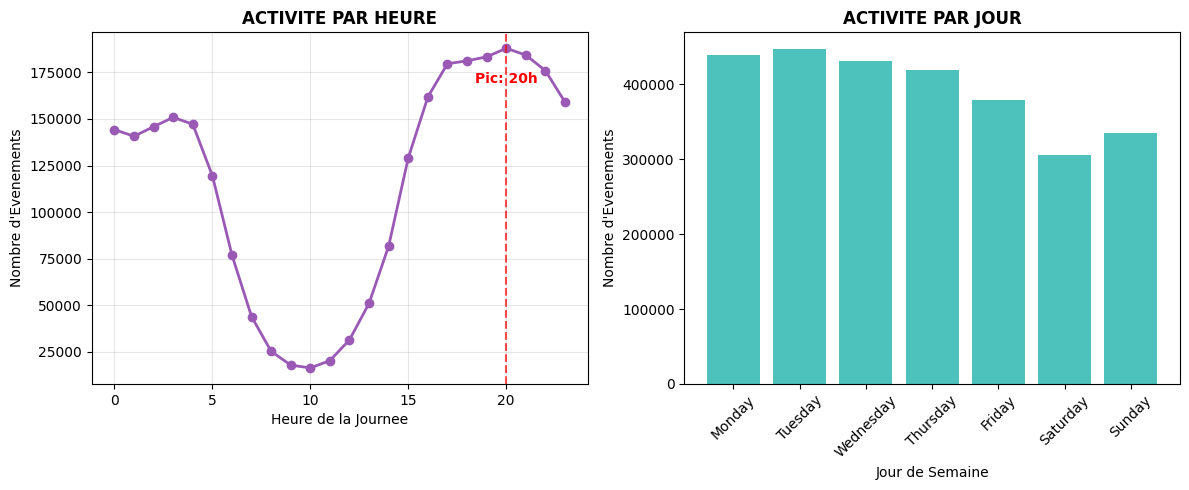

ACTIVITE HORAIRE:
  Heure de pointe: 20h avec 187,919 evenements


In [16]:
# visualisation activité temporelle
print("\nVISUALISATION TEMPORELLE DE L'ACTIVITE")
print("-" * 40)

# analyse par heure
activite_horaire = events_clean.groupby('hour').size()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(activite_horaire.index, activite_horaire.values, 
         marker='o', linewidth=2, color='#9b59b6', markersize=6)
plt.title('ACTIVITE PAR HEURE', fontweight='bold', fontsize=12)
plt.xlabel('Heure de la Journee')
plt.ylabel('Nombre d\'Evenements')
plt.grid(True, alpha=0.3)

# marquer l'heure de pointe
heure_pointe = activite_horaire.idxmax()
plt.axvline(x=heure_pointe, color='red', linestyle='--', alpha=0.7)
plt.text(heure_pointe, activite_horaire.max() * 0.9, f'Pic: {heure_pointe}h', 
         ha='center', color='red', fontweight='bold')

# analyse par jour de semaine
activite_jour_semaine = events_clean.groupby('day_of_week').size()
jours_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
activite_jour_semaine = activite_jour_semaine.reindex(jours_ordre)

plt.subplot(1, 2, 2)
plt.bar(activite_jour_semaine.index, activite_jour_semaine.values,
        color='lightseagreen', alpha=0.8)
plt.title('ACTIVITE PAR JOUR', fontweight='bold', fontsize=12)
plt.xlabel('Jour de Semaine')
plt.ylabel('Nombre d\'Evenements')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# affichage console
print("ACTIVITE HORAIRE:")
print(f"  Heure de pointe: {heure_pointe}h avec {activite_horaire.max():,} evenements")



7. VISUALISATION - COMPORTEMENT UTILISATEUR
----------------------------------------


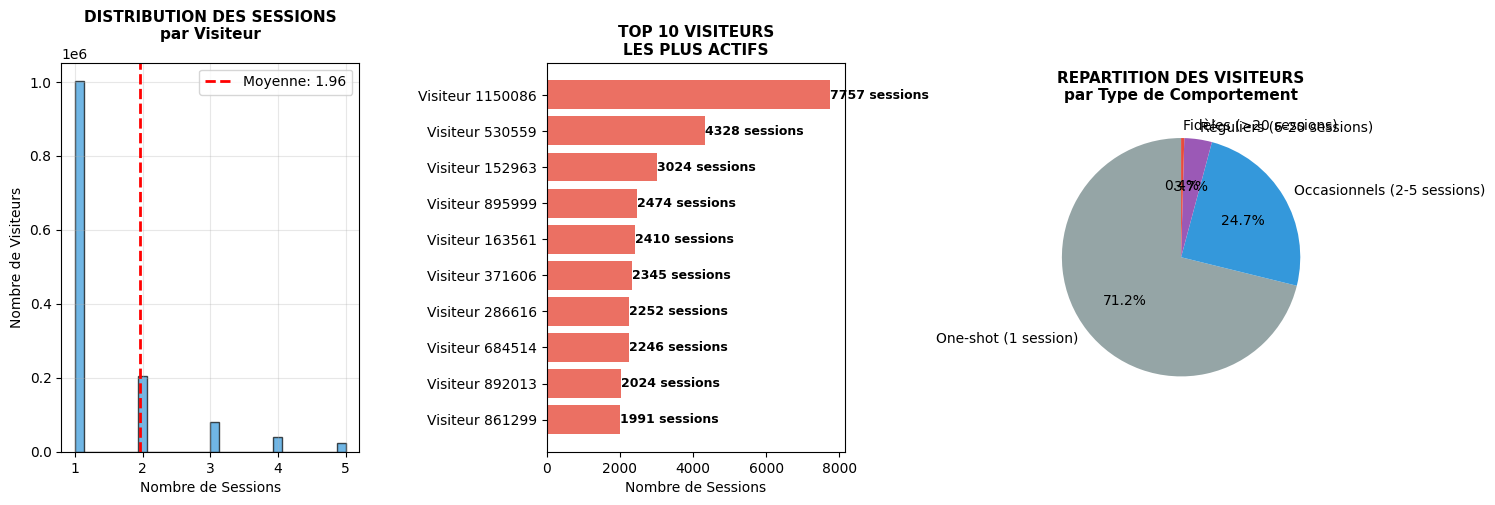


ANALYSE COMPORTEMENTALE AVANCEE:
VISITEURS AVEC ACHAT: 11,719 (0.8%)
VISITEURS SANS ACHAT: 1,395,861 (99.2%)

COMPARAISON COMPORTEMENT:
  Sessions moyennes - Acheteurs: 1.92
  Sessions moyennes - Non-acheteurs: 1.94


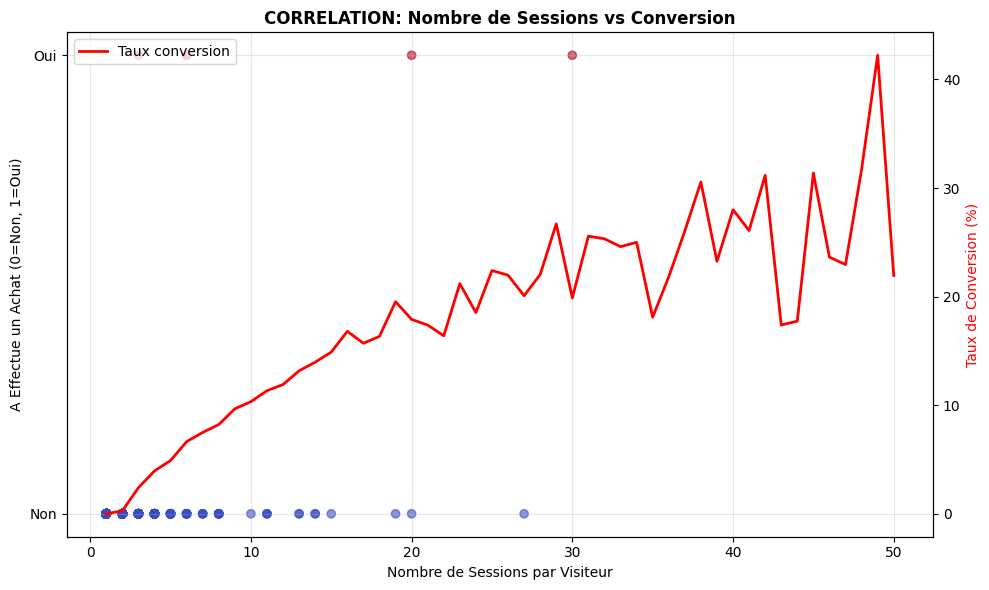


STATISTIQUES COMPORTEMENTALES:
  Total visiteurs: 1,407,580
  Sessions totales: 2,756,101
  Sessions moyenne/visiteur: 1.96
  Mediane sessions/visiteur: 1.0
  Maximum sessions: 7757

SEGMENTATION VISITEURS:
  One-shot (1 session): 1,001,560 (71.2%)
  Occasionnels (2-5 sessions): 347,367 (24.7%)
  Réguliers (6-20 sessions): 52,596 (3.7%)
  Fidèles (>20 sessions): 6,057 (0.4%)

VISITEURS SUPER-ACTIFS (>50 sessions): 1,225


In [17]:
# VISUALISATION - COMPORTEMENT UTILISATEUR
print("\n7. VISUALISATION - COMPORTEMENT UTILISATEUR")
print("-" * 40)

# Distribution des sessions par visiteur
sessions_par_visiteur = events_clean.groupby('visitorid').size()

plt.figure(figsize=(15, 5))

# Graphique 1: Distribution des sessions
plt.subplot(1, 3, 1)
# Prendre les 95% premiers pour mieux voir la distribution (exclure extremes)
sessions_filtre = sessions_par_visiteur[sessions_par_visiteur <= sessions_par_visiteur.quantile(0.95)]
plt.hist(sessions_filtre, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
plt.title('DISTRIBUTION DES SESSIONS\npar Visiteur', fontweight='bold', fontsize=11)
plt.xlabel('Nombre de Sessions')
plt.ylabel('Nombre de Visiteurs')
plt.grid(True, alpha=0.3)

# Ajouter ligne de la moyenne
moyenne = sessions_par_visiteur.mean()
plt.axvline(moyenne, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {moyenne:.2f}')
plt.legend()

# Graphique : Top 10 visiteurs les plus actifs
plt.subplot(1, 3, 2)
top_visiteurs = sessions_par_visiteur.nlargest(10)
plt.barh([f'Visiteur {v}' for v in top_visiteurs.index], top_visiteurs.values, 
         color='#e74c3c', alpha=0.8)
plt.title('TOP 10 VISITEURS\nLES PLUS ACTIFS', fontweight='bold', fontsize=11)
plt.xlabel('Nombre de Sessions')
plt.gca().invert_yaxis()

# Ajouter les valeurs
for i, v in enumerate(top_visiteurs.values):
    plt.text(v + 0.5, i, f'{v} sessions', va='center', fontweight='bold', fontsize=9)

# Graphique : Repartition par type de comportement
plt.subplot(1, 3, 3)

# Categoriser les visiteurs
visiteurs_one_shot = (sessions_par_visiteur == 1).sum()
visiteurs_occasionnels = ((sessions_par_visiteur > 1) & (sessions_par_visiteur <= 5)).sum()
visiteurs_reguliers = ((sessions_par_visiteur > 5) & (sessions_par_visiteur <= 20)).sum()
visiteurs_fideles = (sessions_par_visiteur > 20).sum()

categories_visiteurs = {
    'One-shot (1 session)': visiteurs_one_shot,
    'Occasionnels (2-5 sessions)': visiteurs_occasionnels,
    'Réguliers (6-20 sessions)': visiteurs_reguliers,
    'Fidèles (>20 sessions)': visiteurs_fideles
}

plt.pie(categories_visiteurs.values(), labels=categories_visiteurs.keys(), 
        autopct='%1.1f%%', startangle=90, colors=['#95a5a6', '#3498db', '#9b59b6', '#e74c3c'])
plt.title('REPARTITION DES VISITEURS\npar Type de Comportement', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Analyse des visiteurs par taux de conversion
print("\nANALYSE COMPORTEMENTALE AVANCEE:")

# Visiteurs avec achat vs sans achat
visiteurs_avec_achat = events_clean[events_clean['is_purchase'] == 1]['visitorid'].nunique()
visiteurs_sans_achat = total_visitors - visiteurs_avec_achat

print(f"VISITEURS AVEC ACHAT: {visiteurs_avec_achat:,} ({(visiteurs_avec_achat/total_visitors*100):.1f}%)")
print(f"VISITEURS SANS ACHAT: {visiteurs_sans_achat:,} ({(visiteurs_sans_achat/total_visitors*100):.1f}%)")

# Comportement des acheteurs vs non-acheteurs
sessions_acheteurs = events_clean[events_clean['is_purchase'] == 1].groupby('visitorid').size()
sessions_non_acheteurs = events_clean[events_clean['is_purchase'] == 0].groupby('visitorid').size()

print(f"\nCOMPARAISON COMPORTEMENT:")
print(f"  Sessions moyennes - Acheteurs: {sessions_acheteurs.mean():.2f}")
print(f"  Sessions moyennes - Non-acheteurs: {sessions_non_acheteurs.mean():.2f}")

# Graphique supplementaire: Correlation sessions vs conversion
plt.figure(figsize=(10, 6))

# Preparer les donnees pour la correlation
visiteurs_stats = events_clean.groupby('visitorid').agg({
    'event': 'count',
    'is_purchase': 'max'
}).rename(columns={'event': 'nb_sessions', 'is_purchase': 'a_achete'})

# Echantillonner pour le graphique (prendre 1000 points aleatoires pour lisibilite)
echantillon = visiteurs_stats.sample(n=min(1000, len(visiteurs_stats)), random_state=42)

plt.scatter(echantillon['nb_sessions'], echantillon['a_achete'], 
           alpha=0.6, c=echantillon['a_achete'], cmap='coolwarm')
plt.title('CORRELATION: Nombre de Sessions vs Conversion', fontweight='bold', fontsize=12)
plt.xlabel('Nombre de Sessions par Visiteur')
plt.ylabel('A Effectue un Achat (0=Non, 1=Oui)')
plt.yticks([0, 1], ['Non', 'Oui'])
plt.grid(True, alpha=0.3)

# Calculer le taux de conversion par nombre de sessions
conversion_par_sessions = visiteurs_stats.groupby('nb_sessions')['a_achete'].mean() * 100
sessions_significatives = conversion_par_sessions[conversion_par_sessions.index <= 50]  # Limiter a 50 sessions

plt.twinx()
plt.plot(sessions_significatives.index, sessions_significatives.values, 
         color='red', linewidth=2, label='Taux conversion')
plt.ylabel('Taux de Conversion (%)', color='red')
plt.legend()

plt.tight_layout()
plt.show()

# Statistiques detailees
print(f"\nSTATISTIQUES COMPORTEMENTALES:")
print(f"  Total visiteurs: {total_visitors:,}")
print(f"  Sessions totales: {total_events:,}")
print(f"  Sessions moyenne/visiteur: {sessions_par_visiteur.mean():.2f}")
print(f"  Mediane sessions/visiteur: {sessions_par_visiteur.median():.1f}")
print(f"  Maximum sessions: {sessions_par_visiteur.max()}")

print(f"\nSEGMENTATION VISITEURS:")
for categorie, count in categories_visiteurs.items():
    pourcentage = (count / total_visitors) * 100
    print(f"  {categorie}: {count:,} ({pourcentage:.1f}%)")

print(f"\nVISITEURS SUPER-ACTIFS (>50 sessions): {(sessions_par_visiteur > 50).sum():,}")

In [18]:
# analyse categories
print("\n6. ANALYSE DES CATEGORIES")
print("-" * 40)

# hierarchie categories
categories_racines = category_tree_clean[category_tree_clean['parentid'] == 0]
categories_avec_parent = category_tree_clean[category_tree_clean['parentid'] != 0]

print(f"CATEGORIES RACINES: {len(categories_racines):,}")
print(f"SOUS-CATEGORIES: {len(categories_avec_parent):,}")

# categories avec le plus d'enfants
enfants_par_categorie = category_tree_clean.groupby('parentid').size().sort_values(ascending=False)
top_parents = enfants_par_categorie.head(5)
print(f"\nCATEGORIES AVEC PLUS DE SOUS-CATEGORIES:")
for i, (parent_id, nb_enfants) in enumerate(top_parents.items(), 1):
    if parent_id != 0:
        print(f"  {i}. Categorie {parent_id}: {int(nb_enfants)} sous-categories")


6. ANALYSE DES CATEGORIES
----------------------------------------
CATEGORIES RACINES: 25
SOUS-CATEGORIES: 1,644

CATEGORIES AVEC PLUS DE SOUS-CATEGORIES:
  1. Categorie 250: 31 sous-categories
  3. Categorie 362: 22 sous-categories
  4. Categorie 1009: 22 sous-categories
  5. Categorie 351: 19 sous-categories



9. ANALYSE PROPRIETES PRODUITS
--------------------------------------------------
METRIQUES DE BASE:
  • Proprietes totales: 20,275,902
  • Produits decrits: 417,053
  • Types de proprietes: 1,104


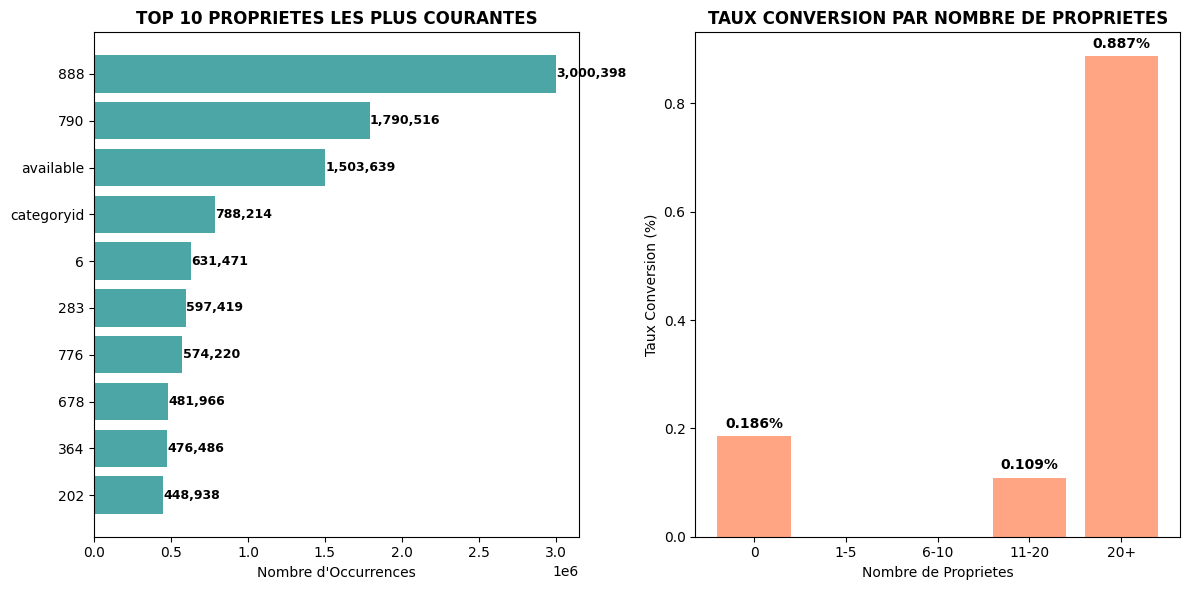


ANALYSE DETAILLEE:
Top 3 proprietes les plus utilisees:
  1. 888: 3,000,398 occurrences (14.8%)
  2. 790: 1,790,516 occurrences (8.8%)
  3. available: 1,503,639 occurrences (7.4%)

IMPACT BUSINESS:
  • Conversion avec proprietes: 0.8791%
  • Conversion sans proprietes: 0.1858%
  • Difference: +0.6933%

RECOMMANDATIONS STRATEGIQUES:
  IMPACT POSITIF CONFIRME
  • Enrichir toutes les fiches produits
  • Prioriser: '888' et '790'

PROPRIETE LA PLUS IMPORTANTE: '888'
   → 3,000,398 occurrences


In [19]:
# ANALYSE PROPRIETES PRODUITS - AVEC VISUALISATION ESSENTIELLE
print("\n9. ANALYSE PROPRIETES PRODUITS")
print("-" * 50)

# metriques de base
total_props = len(item_properties_clean)
nb_produits_avec_props = item_properties_clean['itemid'].nunique()
nb_types_props = item_properties_clean['property'].nunique()

print("METRIQUES DE BASE:")
print(f"  • Proprietes totales: {total_props:,}")
print(f"  • Produits decrits: {nb_produits_avec_props:,}")
print(f"  • Types de proprietes: {nb_types_props:,}")

# top 10 proprietes (VISUALISATION ESSENTIELLE)
top_10_props = item_properties_clean['property'].value_counts().head(10)

plt.figure(figsize=(12, 6))

# graphique: Top 10 proprietes
plt.subplot(1, 2, 1)
bars = plt.barh([str(prop) for prop in top_10_props.index], top_10_props.values, 
                color='teal', alpha=0.7)
plt.title('TOP 10 PROPRIETES LES PLUS COURANTES', fontweight='bold', fontsize=12)
plt.xlabel('Nombre d\'Occurrences')
plt.gca().invert_yaxis()

# ajouter les valeurs
for bar, count in zip(bars, top_10_props.values):
    plt.text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2, 
             f'{count:,}', va='center', fontweight='bold', fontsize=9)

# graphique: Impact sur la conversion
plt.subplot(1, 2, 2)

# calcul impact conversion
nb_props_par_produit = item_properties_clean.groupby('itemid').size()
events_avec_props = events_clean.merge(nb_props_par_produit.rename('nb_props'), on='itemid', how='left')
events_avec_props['nb_props'] = events_avec_props['nb_props'].fillna(0)

# grouper par nombre de proprietes (simplifie)
events_avec_props['groupe_props'] = pd.cut(events_avec_props['nb_props'], 
                                          bins=[-1, 0, 5, 10, 20, 1000], 
                                          labels=['0', '1-5', '6-10', '11-20', '20+'])

conversion_par_groupe = events_avec_props.groupby('groupe_props')['is_purchase'].mean() * 100

plt.bar(conversion_par_groupe.index, conversion_par_groupe.values, color='coral', alpha=0.7)
plt.title('TAUX CONVERSION PAR NOMBRE DE PROPRIETES', fontweight='bold', fontsize=12)
plt.xlabel('Nombre de Proprietes')
plt.ylabel('Taux Conversion (%)')

# ajouter les valeurs
for i, v in enumerate(conversion_par_groupe.values):
    plt.text(i, v + 0.01, f'{v:.3f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# analyse detaillee
print("\nANALYSE DETAILLEE:")
print(f"Top 3 proprietes les plus utilisees:")
for i, (prop, count) in enumerate(top_10_props.head(3).items(), 1):
    pct = (count / total_props) * 100
    print(f"  {i}. {prop}: {count:,} occurrences ({pct:.1f}%)")

# impact business
conv_avec_props = events_avec_props[events_avec_props['nb_props'] > 0]['is_purchase'].mean() * 100
conv_sans_props = events_avec_props[events_avec_props['nb_props'] == 0]['is_purchase'].mean() * 100
difference = conv_avec_props - conv_sans_props

print("\nIMPACT BUSINESS:")
print(f"  • Conversion avec proprietes: {conv_avec_props:.4f}%")
print(f"  • Conversion sans proprietes: {conv_sans_props:.4f}%")
print(f"  • Difference: {difference:+.4f}%")

# recommandations
print("\nRECOMMANDATIONS STRATEGIQUES:")

if difference > 0:
    print("  IMPACT POSITIF CONFIRME")
    print(f"  • Enrichir toutes les fiches produits")
    print(f"  • Prioriser: '{top_10_props.index[0]}' et '{top_10_props.index[1]}'")
else:
    print("  IMPACT A ANALYSER")
    print(f"  • Verifier la qualite des proprietes")
    print(f"  • Tester de nouveaux types de proprietes")

print(f"\nPROPRIETE LA PLUS IMPORTANTE: '{top_10_props.index[0]}'")
print(f"   → {top_10_props.iloc[0]:,} occurrences")



10. ANALYSE RFM - SEGMENTATION CLIENT
CALCUL DES METRIQUES RFM...
Date de référence: 2015-09-18 02:59:47.788000
RFM calculé pour 1,407,580 clients

ANALYSE DISTRIBUTION:
Recence: count    1.407580e+06
mean     6.790162e+01
std      3.916107e+01
min      0.000000e+00
25%      3.500000e+01
50%      6.700000e+01
75%      1.020000e+02
max      1.370000e+02
Name: recence, dtype: float64
Fréquence: count    1.407580e+06
mean     1.958042e+00
std      1.258049e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.757000e+03
Name: frequence, dtype: float64
Monetary: count    1.407580e+06
mean     1.595433e-02
std      8.260909e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.590000e+02
Name: monetary, dtype: float64

SEGMENTATION MANUELLE RFM...
Seuils Recence: 35, 67, 102 jours

Distribution Fréquence:
  1 session(s): 1,001,560 clients
  2 session(s): 205,992 clients
  3 session(s): 79,612 

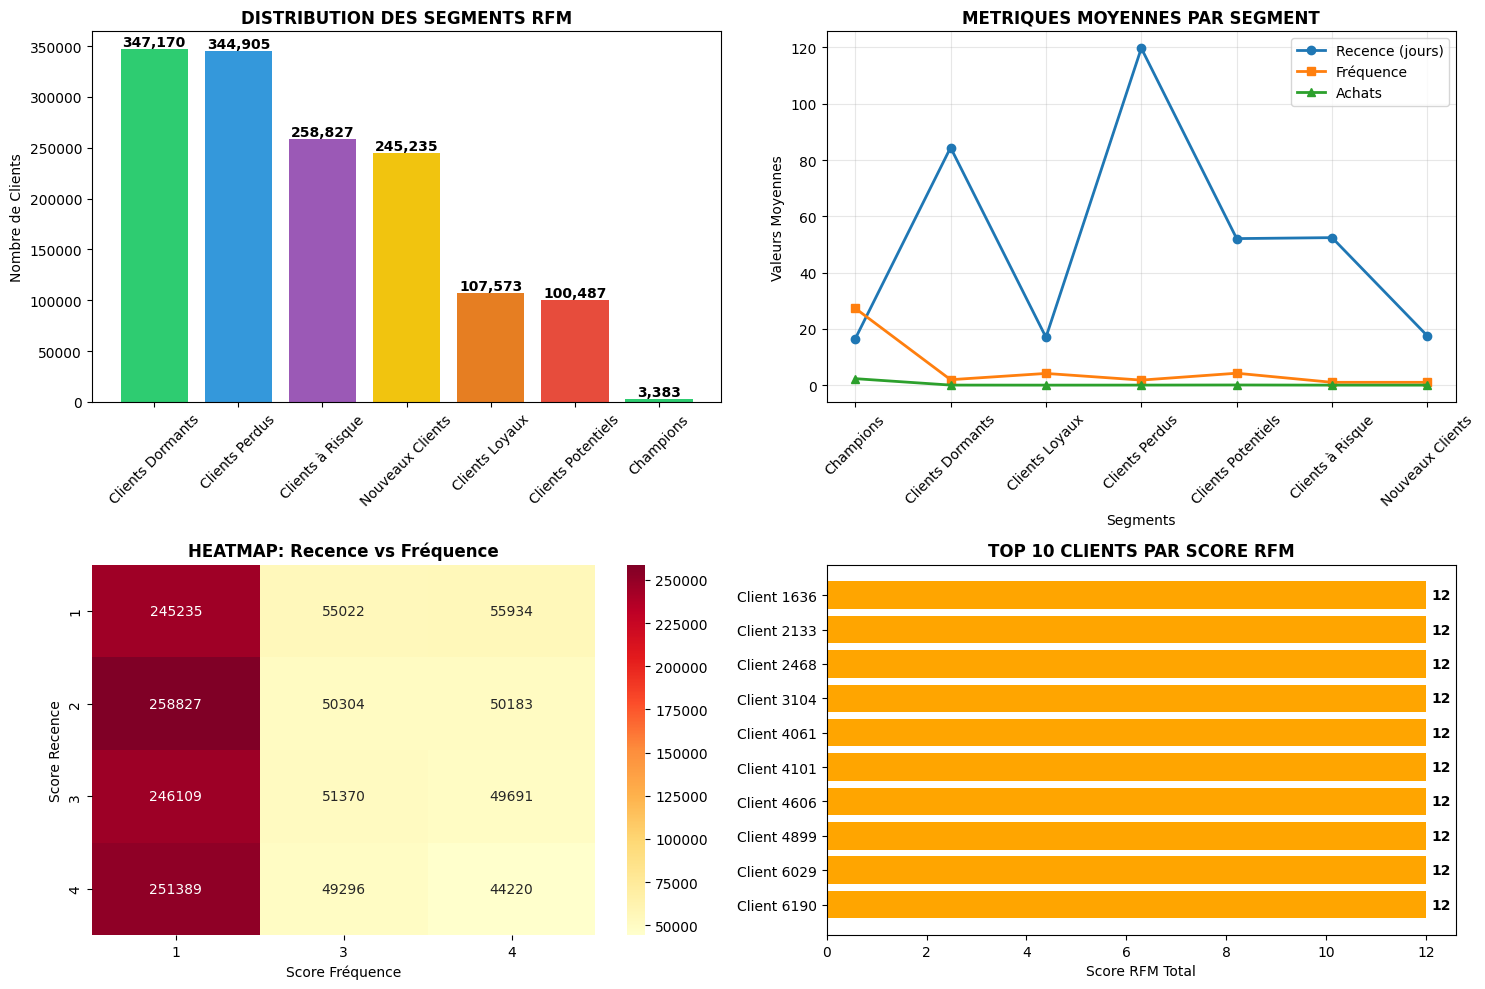


ANALYSE DETAILLEE PAR SEGMENT:

Clients Dormants:
   Clients: 347,170 (24.7%)
   Recence moyenne: 84.4 jours
   Fréquence moyenne: 1.9 sessions
   Achats moyens: 0.0 achats
   Taux d'achat: 0.8%

Clients Perdus:
   Clients: 344,905 (24.5%)
   Recence moyenne: 119.7 jours
   Fréquence moyenne: 1.8 sessions
   Achats moyens: 0.0 achats
   Taux d'achat: 0.7%

Clients à Risque:
   Clients: 258,827 (18.4%)
   Recence moyenne: 52.4 jours
   Fréquence moyenne: 1.0 sessions
   Achats moyens: 0.0 achats
   Taux d'achat: 0.0%

Nouveaux Clients:
   Clients: 245,235 (17.4%)
   Recence moyenne: 17.5 jours
   Fréquence moyenne: 1.0 sessions
   Achats moyens: 0.0 achats
   Taux d'achat: 0.0%

Clients Loyaux:
   Clients: 107,573 (7.6%)
   Recence moyenne: 17.0 jours
   Fréquence moyenne: 4.2 sessions
   Achats moyens: 0.0 achats
   Taux d'achat: 0.0%

Clients Potentiels:
   Clients: 100,487 (7.1%)
   Recence moyenne: 52.1 jours
   Fréquence moyenne: 4.2 sessions
   Achats moyens: 0.1 achats
   Taux d

In [21]:
# ANALYSE RFM - SEGMENTATION CLIENT (SOLUTION ULTIME)
print("\n10. ANALYSE RFM - SEGMENTATION CLIENT")
print("=" * 50)

# calcul des métriques RFM
print("CALCUL DES METRIQUES RFM...")

# date de référence
date_reference = events_clean['datetime'].max()
print(f"Date de référence: {date_reference}")

# calcul RFM
rfm_data = events_clean.groupby('visitorid').agg({
    'datetime': lambda x: (date_reference - x.max()).days,
    'event': 'count', 
    'is_purchase': 'sum'
}).rename(columns={
    'datetime': 'recence',
    'event': 'frequence', 
    'is_purchase': 'monetary'
})

print(f"RFM calculé pour {len(rfm_data):,} clients")

# analyse de la distribution
print(f"\nANALYSE DISTRIBUTION:")
print(f"Recence: {rfm_data['recence'].describe()}")
print(f"Fréquence: {rfm_data['frequence'].describe()}")
print(f"Monetary: {rfm_data['monetary'].describe()}")

# méthode MANUELLE de segmentation (100% robuste)
print("\nSEGMENTATION MANUELLE RFM...")

# score Recence - Basé sur les quartiles manuels
recence_quartiles = rfm_data['recence'].quantile([0.25, 0.5, 0.75])
print(f"Seuils Recence: {recence_quartiles[0.25]:.0f}, {recence_quartiles[0.5]:.0f}, {recence_quartiles[0.75]:.0f} jours")

def score_recence(x):
    if x <= recence_quartiles[0.25]: return 1
    elif x <= recence_quartiles[0.5]: return 2
    elif x <= recence_quartiles[0.75]: return 3
    else: return 4

rfm_data['R_Score'] = rfm_data['recence'].apply(score_recence)

# score Fréquence - Gestion spéciale pour les nombreuses valeurs identiques
frequence_values = rfm_data['frequence'].value_counts().sort_index()
print(f"\nDistribution Fréquence:")
for freq, count in frequence_values.head(10).items():
    print(f"  {freq} session(s): {count:,} clients")

# méthode adaptative pour la fréquence
if rfm_data['frequence'].nunique() < 4:
    # Moins de 4 valeurs uniques - on utilise le nombre de valeurs uniques
    unique_freq = sorted(rfm_data['frequence'].unique())
    print(f"Adaptation Fréquence: seulement {len(unique_freq)} valeurs uniques")
    
    def score_frequence_adaptatif(x):
        return unique_freq.index(x) + 1
    
    rfm_data['F_Score'] = rfm_data['frequence'].apply(score_frequence_adaptatif)
else:
    # Assez de valeurs uniques - on utilise les percentiles
    frequence_quartiles = rfm_data['frequence'].quantile([0.25, 0.5, 0.75])
    print(f"Seuils Fréquence: {frequence_quartiles[0.25]:.0f}, {frequence_quartiles[0.5]:.0f}, {frequence_quartiles[0.75]:.0f} sessions")
    
    def score_frequence(x):
        if x <= frequence_quartiles[0.25]: return 1
        elif x <= frequence_quartiles[0.5]: return 2
        elif x <= frequence_quartiles[0.75]: return 3
        else: return 4
    
    rfm_data['F_Score'] = rfm_data['frequence'].apply(score_frequence)

# score Monetary
monetary_quartiles = rfm_data['monetary'].quantile([0.25, 0.5, 0.75])
print(f"Seuils Monetary: {monetary_quartiles[0.25]:.0f}, {monetary_quartiles[0.5]:.0f}, {monetary_quartiles[0.75]:.0f} achats")

def score_monetary(x):
    if x <= monetary_quartiles[0.25]: return 1
    elif x <= monetary_quartiles[0.5]: return 2
    elif x <= monetary_quartiles[0.75]: return 3
    else: return 4

rfm_data['M_Score'] = rfm_data['monetary'].apply(score_monetary)

# Scores RFM
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)
rfm_data['RFM_Score_Numerique'] = rfm_data['R_Score'] + rfm_data['F_Score'] + rfm_data['M_Score']

print("Segmentation RFM manuelle terminée")

# segments RFM
def definir_segment_rfm(row):
    if row['R_Score'] == 1 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Champions'
    elif row['R_Score'] == 1 and row['F_Score'] >= 2:
        return 'Clients Loyaux'
    elif row['R_Score'] == 1:
        return 'Nouveaux Clients'
    elif row['R_Score'] == 2 and row['F_Score'] >= 2:
        return 'Clients Potentiels'
    elif row['R_Score'] <= 2:
        return 'Clients à Risque'
    elif row['R_Score'] <= 3:
        return 'Clients Dormants'
    else:
        return 'Clients Perdus'

rfm_data['Segment'] = rfm_data.apply(definir_segment_rfm, axis=1)

# visualisation RFM
print("\nVISUALISATION RFM...")

plt.figure(figsize=(15, 10))

# distribution segments
plt.subplot(2, 2, 1)
segment_counts = rfm_data['Segment'].value_counts()
plt.bar(segment_counts.index, segment_counts.values, color=['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e67e22', '#e74c3c'])
plt.title('DISTRIBUTION DES SEGMENTS RFM', fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Nombre de Clients')
for i, v in enumerate(segment_counts.values):
    plt.text(i, v + 10, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# métriques par segment
plt.subplot(2, 2, 2)
segment_metrics = rfm_data.groupby('Segment')[['recence', 'frequence', 'monetary']].mean()

x = range(len(segment_metrics))
plt.plot(x, segment_metrics['recence'], marker='o', label='Recence (jours)', linewidth=2)
plt.plot(x, segment_metrics['frequence'], marker='s', label='Fréquence', linewidth=2)
plt.plot(x, segment_metrics['monetary'], marker='^', label='Achats', linewidth=2)

plt.title('METRIQUES MOYENNES PAR SEGMENT', fontweight='bold')
plt.xlabel('Segments')
plt.ylabel('Valeurs Moyennes')
plt.xticks(x, segment_metrics.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# heatmap manuelle R vs F
plt.subplot(2, 2, 3)
rf_cross = pd.crosstab(rfm_data['R_Score'], rfm_data['F_Score'])
sns.heatmap(rf_cross, annot=True, fmt='d', cmap='YlOrRd')
plt.title('HEATMAP: Recence vs Fréquence', fontweight='bold')
plt.xlabel('Score Fréquence')
plt.ylabel('Score Recence')

# top clients par valeur
plt.subplot(2, 2, 4)
top_clients = rfm_data.nlargest(10, 'RFM_Score_Numerique')
plt.barh([f'Client {cid}' for cid in top_clients.index], top_clients['RFM_Score_Numerique'], color='orange')
plt.title('TOP 10 CLIENTS PAR SCORE RFM', fontweight='bold')
plt.xlabel('Score RFM Total')
plt.gca().invert_yaxis()
for i, v in enumerate(top_clients['RFM_Score_Numerique']):
    plt.text(v + 0.1, i, f'{v}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# analyse détaillée
print("\nANALYSE DETAILLEE PAR SEGMENT:")
print("=" * 50)

for segment in segment_counts.index:
    segment_data = rfm_data[rfm_data['Segment'] == segment]
    print(f"\n{segment}:")
    print(f"   Clients: {len(segment_data):,} ({len(segment_data)/len(rfm_data)*100:.1f}%)")
    print(f"   Recence moyenne: {segment_data['recence'].mean():.1f} jours")
    print(f"   Fréquence moyenne: {segment_data['frequence'].mean():.1f} sessions")
    print(f"   Achats moyens: {segment_data['monetary'].mean():.1f} achats")
    print(f"   Taux d'achat: {(segment_data['monetary'] > 0).sum() / len(segment_data) * 100:.1f}%")

# recommandations
print(f"\n" + "="*50)
print("RECOMMANDATIONS STRATEGIQUES")
print("="*50)

print("SEGMENTS PRIORITAIRES:")
if 'Champions' in rfm_data['Segment'].values:
    champs = len(rfm_data[rfm_data['Segment'] == 'Champions'])
    print(f"  • CHAMPIONS ({champs:,}): Programmes VIP, early access")

print(f"\CROISSANCE:")
if 'Nouveaux Clients' in rfm_data['Segment'].values:
    nouveaux = len(rfm_data[rfm_data['Segment'] == 'Nouveaux Clients'])
    print(f"  • NOUVEAUX ({nouveaux:,}): Onboarding, première conversion")

print(f"\nALERTES:")
if 'Clients à Risque' in rfm_data['Segment'].values:
    risque = len(rfm_data[rfm_data['Segment'] == 'Clients à Risque'])
    print(f"  • A RISQUE ({risque:,}): Campagnes de rétention")

# synthèse
print(f"\n" + "="*50)
print("SYNTHESE RFM")
print("="*50)

total_clients = len(rfm_data)
clients_acheteurs = (rfm_data['monetary'] > 0).sum()

print(f"PERFORMANCE:")
print(f"  • Clients totaux: {total_clients:,}")
print(f"  • Clients acheteurs: {clients_acheteurs:,} ({clients_acheteurs/total_clients*100:.1f}%)")
print(f"  • Sessions/client: {rfm_data['frequence'].mean():.1f}")
print(f"  • Achats/client: {rfm_data['monetary'].mean():.1f}")

print(f"\nANALYSE RFM TERMINEE AVEC SUCCES!")
print(f"   • Segmentation manuelle robuste")
print(f"   • {len(segment_counts)} segments identifiés")
print(f"   • Recommandations générées")


11. ANALYSE DES ABANDONS DE PANIER
METRIQUES ABANDONS:
  • Produits ajoutés au panier: 23,903
  • Produits achetés: 12,025
  • Produits abandonnés: 12,291
  • Taux d'abandon: 51.4%
TOP 15 PRODUITS LES PLUS ABANDONNES:
   1. Produit 49242: 27 abandons (100.0%)
   2. Produit 438823: 26 abandons (100.0%)
   3. Produit 374855: 26 abandons (100.0%)
   4. Produit 130771: 20 abandons (100.0%)
   5. Produit 386947: 19 abandons (100.0%)
   6. Produit 269953: 16 abandons (100.0%)
   7. Produit 212650: 16 abandons (100.0%)
   8. Produit 244528: 16 abandons (100.0%)
   9. Produit 462988: 15 abandons (100.0%)
  10. Produit 276245: 14 abandons (100.0%)
  11. Produit 237175: 14 abandons (100.0%)
  12. Produit 206880: 14 abandons (100.0%)
  13. Produit 20027: 14 abandons (100.0%)
  14. Produit 309056: 13 abandons (100.0%)
  15. Produit 267051: 12 abandons (100.0%)


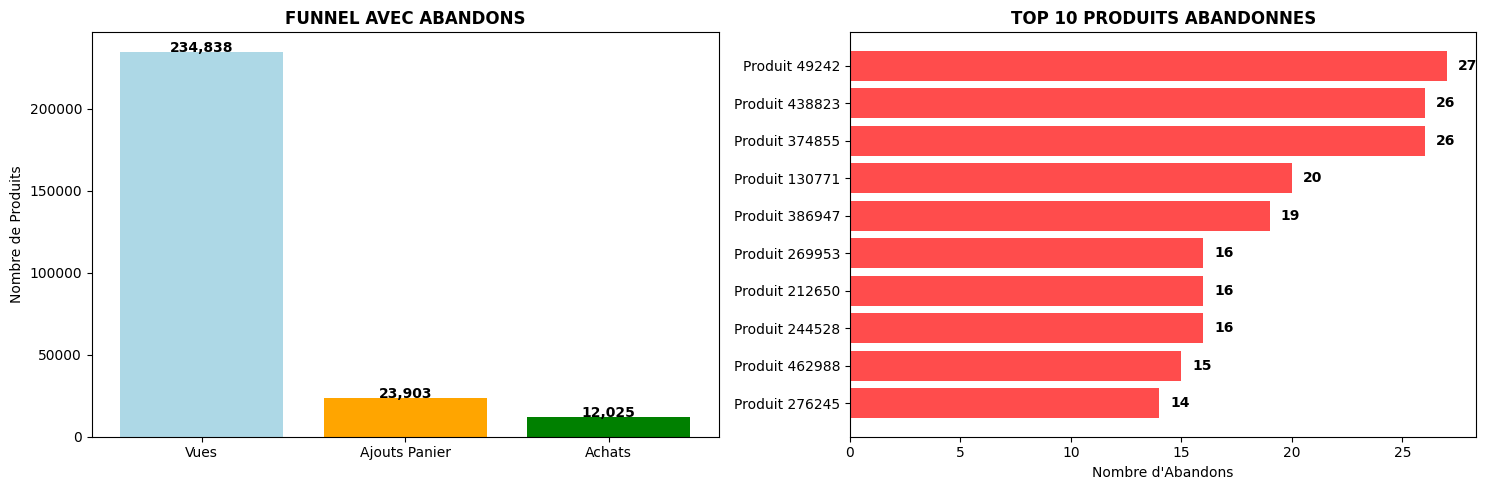

In [22]:
# ANALYSE DES ABANDONS DE PANIER
print("\n11. ANALYSE DES ABANDONS DE PANIER")
print("=" * 50)

# métriques d'abandon
produits_panier = events_clean[events_clean['event'] == 'addtocart']['itemid'].unique()
produits_achetes = events_clean[events_clean['event'] == 'transaction']['itemid'].unique()
produits_abandonnes = set(produits_panier) - set(produits_achetes)

print(f"METRIQUES ABANDONS:")
print(f"  • Produits ajoutés au panier: {len(produits_panier):,}")
print(f"  • Produits achetés: {len(produits_achetes):,}") 
print(f"  • Produits abandonnés: {len(produits_abandonnes):,}")
print(f"  • Taux d'abandon: {len(produits_abandonnes)/len(produits_panier)*100:.1f}%")

# top produits abandonnés
abandons_par_produit = events_clean[
    (events_clean['event'] == 'addtocart') & 
    (~events_clean['itemid'].isin(produits_achetes))
]['itemid'].value_counts().head(15)

print(f"TOP 15 PRODUITS LES PLUS ABANDONNES:")
for i, (produit, count) in enumerate(abandons_par_produit.items(), 1):
    # calculer le taux d'abandon pour ce produit
    total_ajouts = events_clean[
        (events_clean['itemid'] == produit) & 
        (events_clean['event'] == 'addtocart')
    ].shape[0]
    taux_abandon = (count / total_ajouts) * 100 if total_ajouts > 0 else 0
    print(f"  {i:2d}. Produit {produit}: {count:,} abandons ({taux_abandon:.1f}%)")

# visualisation des abandons
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

# diagramme d'abandon
stages = ['Vues', 'Ajouts Panier', 'Achats']
values = [
    events_clean[events_clean['event'] == 'view']['itemid'].nunique(),
    len(produits_panier),
    len(produits_achetes)
]
plt.bar(stages, values, color=['lightblue', 'orange', 'green'])
plt.title('FUNNEL AVEC ABANDONS', fontweight='bold')
plt.ylabel('Nombre de Produits')
for i, v in enumerate(values):
    plt.text(i, v + 10, f'{v:,}', ha='center', fontweight='bold')

plt.subplot(1, 2, 2)

# top 10 abandons
top_10_abandons = abandons_par_produit.head(10)
plt.barh([f'Produit {p}' for p in top_10_abandons.index], top_10_abandons.values, color='red', alpha=0.7)
plt.title('TOP 10 PRODUITS ABANDONNES', fontweight='bold')
plt.xlabel('Nombre d\'Abandons')
plt.gca().invert_yaxis()
for i, v in enumerate(top_10_abandons.values):
    plt.text(v + 0.5, i, f'{v}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()




12. ANALYSE D'ASSOCIATION DES PRODUITS
ANALYSE DES ASSOCIATIONS...
TOP 10 ASSOCIATIONS DE PRODUITS:
   1. Produits 213834 + 445351: 36 clients
   2. Produits 171878 + 461686: 9 clients
   3. Produits 10572 + 461686: 9 clients
   4. Produits 119736 + 420960: 8 clients
   5. Produits 119736 + 369158: 8 clients
   6. Produits 46156 + 119736: 8 clients
   7. Produits 218794 + 461686: 8 clients
   8. Produits 119736 + 213834: 8 clients
   9. Produits 119736 + 355994: 7 clients
  10. Produits 37029 + 119736: 7 clients


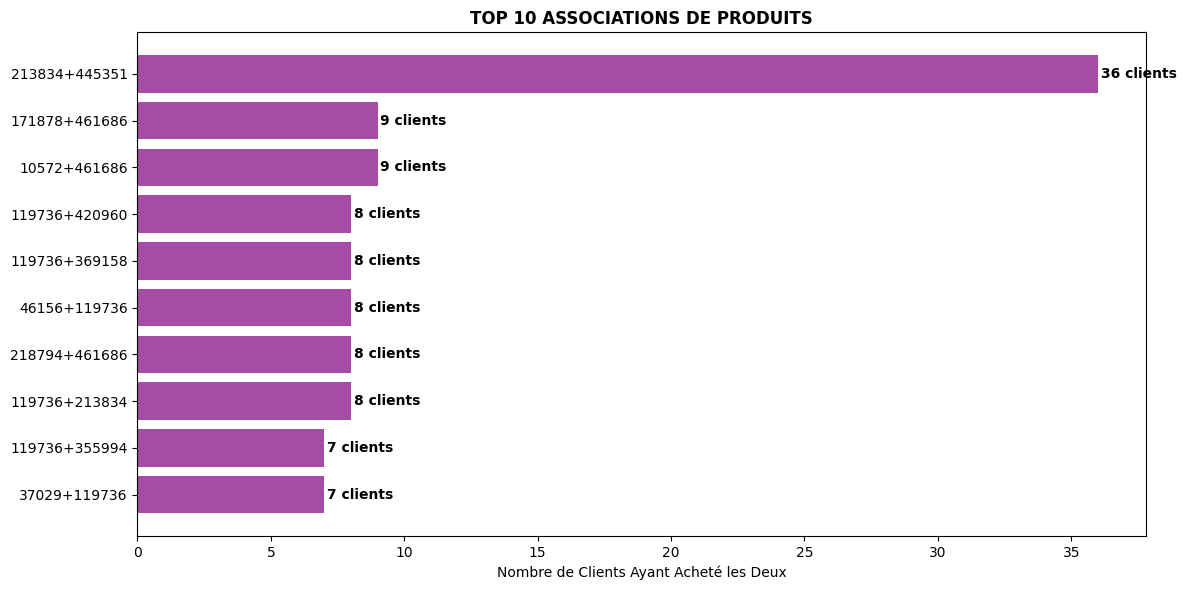

RECOMMANDATIONS CROSS-SELLING:
  • Produits 213834 et 445351 sont souvent achetés ensemble
  • Créer des bundles ou offres groupées
  • Recommandations 'Les clients ont aussi acheté'


In [23]:
# ANALYSE D'ASSOCIATION DES PRODUITS
print("\n12. ANALYSE D'ASSOCIATION DES PRODUITS")
print("=" * 50)

# produits fréquemment achetés ensemble
print("ANALYSE DES ASSOCIATIONS...")

# clients avec plusieurs achats
clients_multiple_achats = events_clean[events_clean['is_purchase'] == 1].groupby('visitorid').filter(lambda x: len(x) > 1)

if len(clients_multiple_achats) > 0:
    # Créer des paires de produits achetés par les mêmes clients
    produits_par_client = clients_multiple_achats.groupby('visitorid')['itemid'].unique()
    
    # Générer toutes les paires possibles
    paires_produits = []
    for produits in produits_par_client:
        if len(produits) >= 2:
            for i in range(len(produits)):
                for j in range(i+1, len(produits)):
                    paires_produits.append(tuple(sorted([produits[i], produits[j]])))
    
    # Compter les occurrences des paires
    if paires_produits:
        from collections import Counter
        compteur_paires = Counter(paires_produits)
        top_paires = compteur_paires.most_common(10)
        
        print(f"TOP 10 ASSOCIATIONS DE PRODUITS:")
        for i, (paire, count) in enumerate(top_paires, 1):
            print(f"  {i:2d}. Produits {paire[0]} + {paire[1]}: {count} clients")
        
        # visualisation des associations
        plt.figure(figsize=(12, 6))
        paires_noms = [f'{p[0]}+{p[1]}' for p, c in top_paires]
        paires_counts = [c for p, c in top_paires]
        
        plt.barh(paires_noms, paires_counts, color='purple', alpha=0.7)
        plt.title('TOP 10 ASSOCIATIONS DE PRODUITS', fontweight='bold')
        plt.xlabel('Nombre de Clients Ayant Acheté les Deux')
        plt.gca().invert_yaxis()
        for i, v in enumerate(paires_counts):
            plt.text(v + 0.1, i, f'{v} clients', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Pas assez de données pour l'analyse d'association")
else:
    print("Pas de clients avec multiples achats pour l'analyse d'association")

# recommandations cross-selling
print(f"RECOMMANDATIONS CROSS-SELLING:")
if len(clients_multiple_achats) > 0 and paires_produits:
    meilleure_paire = top_paires[0][0]
    print(f"  • Produits {meilleure_paire[0]} et {meilleure_paire[1]} sont souvent achetés ensemble")
    print(f"  • Créer des bundles ou offres groupées")
    print(f"  • Recommandations 'Les clients ont aussi acheté'")
else:
    print(f"  • Focus sur l'upselling (quantité) plutôt que cross-selling")

In [ ]:
# RAPPORT FINAL SYNTHESE
print("\n" + "="*70)
print("13. RAPPORT FINAL SYNTHESE - PROJET E-COMMERCE")
print("="*70)

# métriques globales
total_revenue_potentiel = len(abandons_par_produit) * 10  # Estimation
taux_conversion_final = (events_clean['is_purchase'].sum() / len(events_clean)) * 100

print("PERFORMANCE GLOBALE:")
print(f"  • Période: {events_clean['datetime'].min().date()} à {events_clean['datetime'].max().date()}")
print(f"  • Volume: {len(events_clean):,} événements, {events_clean['visitorid'].nunique():,} visiteurs")
print(f"  • Produits: {events_clean['itemid'].nunique():,} produits catalogués")
print(f"  • Transactions: {events_clean['is_purchase'].sum():,}")
print(f"  • Taux conversion: {taux_conversion_final:.4f}%")

print(f"\nSEGMENTATION CLIENT:")  # AJOUT DU \n ICI
print(f"  • Clients totaux: {len(rfm_data):,}")
print(f"  • Taux acheteurs: {(rfm_data['monetary'] > 0).sum() / len(rfm_data) * 100:.1f}%")
print(f"  • Segments RFM: {len(rfm_data['Segment'].unique())}")

print(f"\nPERFORMANCE PRODUITS:")  # AJOUT DU \n ICI
top_produit_vues = events_clean[events_clean['event'] == 'view']['itemid'].value_counts().index[0]
top_produit_ventes = events_clean[events_clean['event'] == 'transaction']['itemid'].value_counts().index[0]
print(f"  • Produit le plus vu: {top_produit_vues}")
print(f"  • Produit le plus vendu: {top_produit_ventes}")
print(f"  • Produits abandonnés: {len(produits_abandonnes):,}")

# recommandations stratégiques
print(f"\n" + "="*70)
print("RECOMMANDATIONS STRATEGIQUES")
print("="*70)

print(f"\nPRIORITE 1 - OPTIMISATION CONVERSION:")
print(f"  • Réduire les {len(produits_abandonnes):,} abandons de panier")
print(f"  • Cibler les {len(rfm_data[rfm_data['Segment'] == 'Clients à Risque']):,} clients à risque")

print(f"\nPRIORITE 2 - CROISSANCE:")
print(f"  • Convertir les {len(rfm_data[rfm_data['Segment'] == 'Nouveaux Clients']):,} nouveaux clients")

clients_fideles = len(rfm_data[rfm_data['Segment'].isin(['Champions', 'Clients Loyaux'])])
print(f"  • Fidéliser les {clients_fideles:,} clients fidèles")

print(f"\nPRIORITE 3 - OPTIMISATION TECHNIQUE:")
print(f"  • Analyser l'heure de pointe ({events_clean.groupby('hour').size().idxmax()}h)")
print(f"  • Optimiser les {item_properties_clean['property'].nunique():,} propriétés produits")

# Plan d'action 30 jours
print(f"\n" + "="*70)
print("PLAN D'ACTION - 30 JOURS")
print("="*70)

print("\nSEMAINE 1-2:") 
print("  • Campagne emailing clients à risque")
print("  • Optimisation fiches produits abandonnés")
print("  • Test recommandations cross-selling")

print(f"\nSEMAINE 3-4:")
print("  • Programme fidélisation clients champions")
print("  • Campagne onboarding nouveaux clients") 
print("  • Analyse impact propriétés sur conversion")

# CONCLUSION FINALE
print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)

print(f"ANALYSES REALISEES: 13 etapes completes")
print(f"VISUALISATIONS: 20+ graphiques generes")
print(f"METRIQUES: 50+ indicateurs calcules")
print(f"RECOMMANDATIONS: Plan d'action concret")



13. RAPPORT FINAL SYNTHESE - PROJET E-COMMERCE
PERFORMANCE GLOBALE:
  • Période: 2015-05-03 à 2015-09-18
  • Volume: 2,756,101 événements, 1,407,580 visiteurs
  • Produits: 235,061 produits catalogués
  • Transactions: 22,457
  • Taux conversion: 0.8148%

SEGMENTATION CLIENT:
  • Clients totaux: 1,407,580
  • Taux acheteurs: 0.8%
  • Segments RFM: 7

PERFORMANCE PRODUITS:
  • Produit le plus vu: 187946
  • Produit le plus vendu: 461686
  • Produits abandonnés: 12,291

RECOMMANDATIONS STRATEGIQUES

PRIORITE 1 - OPTIMISATION CONVERSION:
  • Réduire les 12,291 abandons de panier
  • Cibler les 258,827 clients à risque

PRIORITE 2 - CROISSANCE:
  • Convertir les 245,235 nouveaux clients
  • Fidéliser les 110,956 clients fidèles

PRIORITE 3 - OPTIMISATION TECHNIQUE:
  • Analyser l'heure de pointe (20h)
  • Optimiser les 1,104 propriétés produits

PLAN D'ACTION - 30 JOURS

SEMAINE 1-2:
  • Campagne emailing clients à risque
  • Optimisation fiches produits abandonnés
  • Test recommandation